#DEPENDENCIES & FUNCTIONS

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# define layer
layer = InstanceNormalization(axis=-1)

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-xh0pev_6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-xh0pev_6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=3788019f543ce8874727b032d291a7c318b44e75a1fa297e96cb334d5b71beec
  Stored in directory: /tmp/pip-ephem-wheel-cache-i4i5nqs6/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):#cam_path="cam.jpg"
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img_path)
    #img = preprocessing_fun(img)
    print('',img.shape)
    for ii in range(1,15):
      if min(img[:,img.shape[1]-1,0]) > 200:
        img = img[0:img.shape[0],0:img.shape[1]-1]
      if min(img[:,1,0]) >200:
        img = img[0:img.shape[0],1:img.shape[1]]
      if min(img[img.shape[0]-1,:,0]) > 200:
        img = img[0:img.shape[0]-1,0:img.shape[1]]
      if min(img[1,:,0]) >200:
        img = img[1:img.shape[0],0:img.shape[1]]
    #print('',img.shape)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("gist_gray")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img1 = cv2.cvtColor(np.array(superimposed_img), cv2.COLOR_BGR2GRAY)
    #plt.imshow(superimposed_img1,cmap='gray')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return superimposed_img1,img

def cropped_best_image(img_with_hm,img,box_size):
  #box_size=[150,150]
  sums1=[]
  for ii in range(np.shape(img)[0]-box_size[0]):
    for jj in range(np.shape(img)[1]-box_size[1]):
      sum=0
      for xx in range(box_size[0]):
        for yy in range(box_size[1]):
          if img_with_hm[ii+xx,jj+yy] > 235:
            sum = sum + img_with_hm[ii+xx,jj+yy]
      sums1.append([sum,ii,jj])
  sums1 = np.array(sums1)
  arg = np.argmax(sums1[:,0])
  imax = sums1[arg,1]
  jmax = sums1[arg,2]
  imgfinal = img[imax:imax+box_size[0],jmax:jmax+box_size[1]]
  return imgfinal

def preprocessing_fun1(filename):
    desired_size = 224
    #print('',filename)
    #img = cv2.imread(filename)
    img = filename
    old_size = np.shape(img)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img= cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [255, 255, 255]
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[256, 256, 3])

  return cropped_image

def GetLastConvLayerOutput(model, img_array, last_conv_layer_name):
  img_array11 = CroppedImage(img_array)
  #print('',np.shape(img_array))
  #img_array11 = cv2.cvtColor(np.array(img_array11,np.uint8), cv2.COLOR_BGR2GRAY)
  img_array12 = image_enhancer.enhance(img_array11)
  out = np.ones((img_array12.shape[0],img_array12.shape[1])) -img_array12
  img_array = torchvision.transforms.ToPILImage()(np.uint8(255*out))
  img_array = cv2.cvtColor(np.float32(img_array), cv2.COLOR_GRAY2BGR)
  img_array = preprocessing_fun(img_array)
  img_array = expand_dims(img_array, 0)
  img_array = (img_array - 127.5) / 127.5
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
  last_conv_layer_output, preds = grad_model(img_array)
  return last_conv_layer_output, img_array

def CroppedImage(img):
  for ii in range(1,50):
    if min(img[:,img.shape[1]-1]) > 127:
      img = img[0:img.shape[0],0:img.shape[1]-1]
    if min(img[:,1]) >127:
      img = img[0:img.shape[0],1:img.shape[1]]
    if min(img[img.shape[0]-1,:]) > 127:
      img = img[0:img.shape[0]-1,0:img.shape[1]]
    if min(img[1,:]) >127:
      img = img[1:img.shape[0],0:img.shape[1]]

  #sigma = 0.1
  #img = np.array(255*random_noise(img, mode ='s&p',amount = 0.2),dtype = np.uint8)#var=sigma
  return img
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [275, 275],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)
  # random mirroring
  image = tf.keras.preprocessing.image.random_rotation(image, 40, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest',
    cval=0.0, interpolation_order=1)
  #image = tf.image.random_flip_left_right(image)

  return image
def preprocessing_fun(filename):
    desired_size = 256
    #print('',filename)
    #img = cv2.imread(filename)
    img = filename
    old_size = np.shape(img)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img= cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [255, 255, 255]
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return img

def Nmaxelements(list1, N):
    final_list = []
  
    for i in range(0, N): 
        max1 = 0
        b1=0
        for j in range(len(list1)):     
            if list1[j] > max1:
              max1 = list1[j]
              b1= j
                  
        list1.remove(max1)
        final_list.append([max1,b1])
        
    return final_list
    
def load_image(filename, size=(256,256)):
  img = cv2.imread(filename)
  img = preprocessing_fun(img)
  pixels = expand_dims(img, 0)
  pixels = (pixels - 127.5) / 127.5
  return pixels

def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()
 
def DescOrderSort_Variance(last_conv_layer_output):
  Var_scores=[]
  for ij in range(256):
    grayB = np.array(last_conv_layer_output[0,:,:,ij])
    Var_scores.append(ndimage.variance(grayB))
  return Nmaxelements(Var_scores,256)

def Plot_LastConvLayer(last_conv_layer_output):
  f, axarr = plt.subplots(16,8,figsize=(14,20))
  ij=0
  for ii in range(16):
    for jj in range(8):
      axarr[ii,jj].imshow(last_conv_layer_output[0,:,:,ij])
'''
def Upsampled_BtoAmodel(model, last_conv_layer_output):
  l1 = model.get_layer('instance_normalization_24')
  l2 = l1(last_conv_layer_output)
  l21 = model.get_layer('activation_17')
  l3 = l21(l2)
  l31 = model.get_layer('conv2d_21')
  l4 = l31(l3)
  l41 = model.get_layer('instance_normalization_25')
  l5 = l41(l4)
  l51 = model.get_layer('activation_18')
  l6 = l51(l5)
  l61 = model.get_layer('conv2d_22')
  l7 = l61(l6)
  l71 = model.get_layer('instance_normalization_26')
  l8 = l71(l7)
  l81 = model.get_layer('concatenate_6')
  l9 = l81([l8,l3])
  #l9 = tf.keras.layers.Concatenate(axis=1)([l8, l21])
  l91 = model.get_layer('conv2d_23')
  l10 = l91(l9)
  l101 = model.get_layer('instance_normalization_27')
  l11 = l101(l10)
  l111 = model.get_layer('activation_19')
  l12 = l111(l11)
  l121 = model.get_layer('conv2d_24')
  l13 = l121(l12)
  l131 = model.get_layer('instance_normalization_28')
  l14 = l131(l13)
  l141 = model.get_layer('concatenate_7')
  l15 = l141([l14,l9])
  l151 = model.get_layer('conv2d_25')
  l16 = l151(l15)
  l161 = model.get_layer('instance_normalization_29')
  l17 = l161(l16)
  l171 = model.get_layer('activation_20')
  l18 = l171(l17)
  l181 = model.get_layer('conv2d_26')
  l19 = l181(l18)
  l191 = model.get_layer('instance_normalization_30')
  l20 = l191(l19)
  l201 = model.get_layer('concatenate_8')
  l21 = l201([l20,l15])
  l211 = model.get_layer('conv2d_27')
  l22 = l211(l21)
  l221 = model.get_layer('instance_normalization_31')
  l23 = l221(l22) 
  l231 = model.get_layer('activation_21')
  l24 = l231(l23) 
  l241 = model.get_layer('conv2d_28')
  l25 = l241(l24) 
  l251 = model.get_layer('instance_normalization_32')
  l26 = l251(l25)
  l261 = model.get_layer('concatenate_9')
  l27 = l261([l26,l21])
  l271 = model.get_layer('conv2d_29')
  l28 = l271(l27)
  l281 = model.get_layer('instance_normalization_33')
  l29 = l281(l28)
  l291 = model.get_layer('activation_22')
  l30 = l291(l29)
  l301 = model.get_layer('conv2d_30')
  l31 = l301(l30)
  l311 = model.get_layer('instance_normalization_34')
  l32 = l311(l31)
  l321 = model.get_layer('concatenate_10')
  l33 = l321([l32,l27])
  l331 = model.get_layer('conv2d_31')
  l34 = l331(l33)
  l341 = model.get_layer('instance_normalization_35')
  l35 = l341(l34)
  l351 = model.get_layer('activation_23')
  l36 = l351(l35)
  l361 = model.get_layer('conv2d_32')
  l37 = l361(l36)
  l371 = model.get_layer('instance_normalization_36')
  l38 = l371(l37)
  l381 = model.get_layer('concatenate_11')
  l39 = l381([l38,l33])
  l391 = model.get_layer('conv2d_transpose_3')
  l40 = l391(l39)
  l401 = model.get_layer('instance_normalization_37')
  l41 = l401(l40)
  l411 = model.get_layer('activation_24')
  l42 = l411(l41)
  l421 = model.get_layer('conv2d_transpose_4')
  l43 = l421(l42)
  l431 = model.get_layer('instance_normalization_38')
  l44 = l431(l43)
  l441 = model.get_layer('activation_25')
  l45 = l441(l44)
  l451 = model.get_layer('conv2d_transpose_5')
  l46 = l451(l45)
  l461 = model.get_layer('instance_normalization_39')
  l47 = l461(l46)
  l471 = model.get_layer('activation_26')
  l48 = l471(l47)
  l481 = model.get_layer('conv2d_33')
  l49 = l481(l48)
  l491 = model.get_layer('instance_normalization_40')
  l50 = l491(l49)
  l501 = model.get_layer('activation_27')
  l51 = l501(l50)
  return l51
'''
def Upsampled_AtoBmodel(model1, last_conv_layer_output1):
  l1 = model1.get_layer('instance_normalization_3')
  l2 = l1(last_conv_layer_output1)
  l21 = model1.get_layer('activation_2')
  l3 = l21(l2)
  l31 = model1.get_layer('conv2d_3')
  l4 = l31(l3)
  l41 = model1.get_layer('instance_normalization_4')
  l5 = l41(l4)
  l51 = model1.get_layer('activation_3')
  l6 = l51(l5)
  l61 = model1.get_layer('conv2d_4')
  l7 = l61(l6)
  l71 = model1.get_layer('instance_normalization_5')
  l8 = l71(l7)
  l81 = model1.get_layer('concatenate')
  l9 = l81([l8,l3])
  l91 = model1.get_layer('conv2d_5')
  l10 = l91(l9)
  l101 = model1.get_layer('instance_normalization_6')
  l11 = l101(l10)
  l111 = model1.get_layer('activation_4')
  l12 = l111(l11)
  l121 = model1.get_layer('conv2d_6')
  l13 = l121(l12)
  l131 = model1.get_layer('instance_normalization_7')
  l14 = l131(l13)
  l141 = model1.get_layer('concatenate_1')
  l15 = l141([l14,l9])
  l151 = model1.get_layer('conv2d_7')
  l16 = l151(l15)
  l161 = model1.get_layer('instance_normalization_8')
  l17 = l161(l16)
  l171 = model1.get_layer('activation_5')
  l18 = l171(l17)
  l181 = model1.get_layer('conv2d_8')
  l19 = l181(l18)
  l191 = model1.get_layer('instance_normalization_9')
  l20 = l191(l19)
  l201 = model1.get_layer('concatenate_2')
  l21 = l201([l20,l15])
  l211 = model1.get_layer('conv2d_9')
  l22 = l211(l21)
  l221 = model1.get_layer('instance_normalization_10')
  l23 = l221(l22) 
  l231 = model1.get_layer('activation_6')
  l24 = l231(l23) 
  l241 = model1.get_layer('conv2d_10')
  l25 = l241(l24) 
  l251 = model1.get_layer('instance_normalization_11')
  l26 = l251(l25)
  l261 = model1.get_layer('concatenate_3')
  l27 = l261([l26,l21])
  l271 = model1.get_layer('conv2d_11')
  l28 = l271(l27)
  l281 = model1.get_layer('instance_normalization_12')
  l29 = l281(l28)
  l291 = model1.get_layer('activation_7')
  l30 = l291(l29)
  l301 = model1.get_layer('conv2d_12')
  l31 = l301(l30)
  l311 = model1.get_layer('instance_normalization_13')
  l32 = l311(l31)
  l321 = model1.get_layer('concatenate_4')
  l33 = l321([l32,l27])
  l331 = model1.get_layer('conv2d_13')
  l34 = l331(l33)
  l341 = model1.get_layer('instance_normalization_14')
  l35 = l341(l34)
  l351 = model1.get_layer('activation_8')
  l36 = l351(l35)
  l361 = model1.get_layer('conv2d_14')
  l37 = l361(l36)
  l371 = model1.get_layer('instance_normalization_15')
  l38 = l371(l37)
  l381 = model1.get_layer('concatenate_5')
  l39 = l381([l38,l33])
  l391 = model1.get_layer('conv2d_transpose')
  l40 = l391(l39)
  l401 = model1.get_layer('instance_normalization_16')
  l41 = l401(l40)
  l411 = model1.get_layer('activation_9')
  l42 = l411(l41)
  l421 = model1.get_layer('conv2d_transpose_1')
  l43 = l421(l42)
  l431 = model1.get_layer('instance_normalization_17')
  l44 = l431(l43)
  l441 = model1.get_layer('activation_10')
  l45 = l441(l44)
  l451 = model1.get_layer('conv2d_15')
  l46 = l451(l45)
  l461 = model1.get_layer('instance_normalization_18')
  l47 = l461(l46)
  l471 = model1.get_layer('activation_11')
  l48 = l471(l47)
  return l48 

def load_image(filename, size=(256,256)):
  img = cv2.imread(filename)
  img = preprocessing_fun(img)
  pixels = expand_dims(img, 0)
  #scale from [0,255] to [-1,1]
  pixels = (pixels - 127.5) / 127.5
  return pixels

def Upsampled2_AtoBmodel(model1, last_conv_layer_output1):
  l1 = model1.get_layer('instance_normalization_47')
  l2 = l1(last_conv_layer_output1)
  l21 = model1.get_layer('activation_26')
  l3 = l21(l2)
  l31 = model1.get_layer('conv2d_47')
  l4 = l31(l3)
  l41 = model1.get_layer('instance_normalization_48')
  l5 = l41(l4)
  l51 = model1.get_layer('activation_27')
  l6 = l51(l5)
  l61 = model1.get_layer('conv2d_48')
  l7 = l61(l6)
  l71 = model1.get_layer('instance_normalization_49')
  l8 = l71(l7)
  l81 = model1.get_layer('concatenate_12')
  l9 = l81([l8,l3])
  l91 = model1.get_layer('conv2d_49')
  l10 = l91(l9)
  l101 = model1.get_layer('instance_normalization_50')
  l11 = l101(l10)
  l111 = model1.get_layer('activation_28')
  l12 = l111(l11)
  l121 = model1.get_layer('conv2d_50')
  l13 = l121(l12)
  l131 = model1.get_layer('instance_normalization_51')
  l14 = l131(l13)
  l141 = model1.get_layer('concatenate_13')
  l15 = l141([l14,l9])
  l151 = model1.get_layer('conv2d_51')
  l16 = l151(l15)
  l161 = model1.get_layer('instance_normalization_52')
  l17 = l161(l16)
  l171 = model1.get_layer('activation_29')
  l18 = l171(l17)
  l181 = model1.get_layer('conv2d_52')
  l19 = l181(l18)
  l191 = model1.get_layer('instance_normalization_53')
  l20 = l191(l19)
  l201 = model1.get_layer('concatenate_14')
  l21 = l201([l20,l15])
  l211 = model1.get_layer('conv2d_53')
  l22 = l211(l21)
  l221 = model1.get_layer('instance_normalization_54')
  l23 = l221(l22) 
  l231 = model1.get_layer('activation_30')
  l24 = l231(l23) 
  l241 = model1.get_layer('conv2d_54')
  l25 = l241(l24) 
  l251 = model1.get_layer('instance_normalization_55')
  l26 = l251(l25)
  l261 = model1.get_layer('concatenate_15')
  l27 = l261([l26,l21])
  l271 = model1.get_layer('conv2d_55')
  l28 = l271(l27)
  l281 = model1.get_layer('instance_normalization_56')
  l29 = l281(l28)
  l291 = model1.get_layer('activation_31')
  l30 = l291(l29)
  l301 = model1.get_layer('conv2d_56')
  l31 = l301(l30)
  l311 = model1.get_layer('instance_normalization_57')
  l32 = l311(l31)
  l321 = model1.get_layer('concatenate_16')
  l33 = l321([l32,l27])
  l331 = model1.get_layer('conv2d_57')
  l34 = l331(l33)
  l341 = model1.get_layer('instance_normalization_58')
  l35 = l341(l34)
  l351 = model1.get_layer('activation_32')
  l36 = l351(l35)
  l361 = model1.get_layer('conv2d_58')
  l37 = l361(l36)
  l371 = model1.get_layer('instance_normalization_59')
  l38 = l371(l37)
  l381 = model1.get_layer('concatenate_17')
  l39 = l381([l38,l33])
  l391 = model1.get_layer('conv2d_transpose_4')
  l40 = l391(l39)
  l401 = model1.get_layer('instance_normalization_60')
  l41 = l401(l40)
  l411 = model1.get_layer('activation_33')
  l42 = l411(l41)
  l421 = model1.get_layer('conv2d_transpose_5')
  l43 = l421(l42)
  l431 = model1.get_layer('instance_normalization_61')
  l44 = l431(l43)
  l441 = model1.get_layer('activation_34')
  l45 = l441(l44)
  l451 = model1.get_layer('conv2d_59')
  l46 = l451(l45)
  l461 = model1.get_layer('instance_normalization_62')
  l47 = l461(l46)
  l471 = model1.get_layer('activation_35')
  l48 = l471(l47)
  return l48

def Upsampled2_BtoAmodel(model1, last_conv_layer_output1):
  l1 = model1.get_layer('instance_normalization_21')
  l2 = l1(last_conv_layer_output1)
  l21 = model1.get_layer('activation_14')
  l3 = l21(l2)
  l31 = model1.get_layer('conv2d_19')
  l4 = l31(l3)
  l41 = model1.get_layer('instance_normalization_22')
  l5 = l41(l4)
  l51 = model1.get_layer('activation_15')
  l6 = l51(l5)
  l61 = model1.get_layer('conv2d_20')
  l7 = l61(l6)
  l71 = model1.get_layer('instance_normalization_23')
  l8 = l71(l7)
  l81 = model1.get_layer('concatenate_6')
  l9 = l81([l8,l3])
  l91 = model1.get_layer('conv2d_21')
  l10 = l91(l9)
  l101 = model1.get_layer('instance_normalization_24')
  l11 = l101(l10)
  l111 = model1.get_layer('activation_16')
  l12 = l111(l11)
  l121 = model1.get_layer('conv2d_22')
  l13 = l121(l12)
  l131 = model1.get_layer('instance_normalization_25')
  l14 = l131(l13)
  l141 = model1.get_layer('concatenate_7')
  l15 = l141([l14,l9])
  l151 = model1.get_layer('conv2d_23')
  l16 = l151(l15)
  l161 = model1.get_layer('instance_normalization_26')
  l17 = l161(l16)
  l171 = model1.get_layer('activation_17')
  l18 = l171(l17)
  l181 = model1.get_layer('conv2d_24')
  l19 = l181(l18)
  l191 = model1.get_layer('instance_normalization_27')
  l20 = l191(l19)
  l201 = model1.get_layer('concatenate_8')
  l21 = l201([l20,l15])
  l211 = model1.get_layer('conv2d_25')
  l22 = l211(l21)
  l221 = model1.get_layer('instance_normalization_28')
  l23 = l221(l22) 
  l231 = model1.get_layer('activation_18')
  l24 = l231(l23) 
  l241 = model1.get_layer('conv2d_26')
  l25 = l241(l24) 
  l251 = model1.get_layer('instance_normalization_29')
  l26 = l251(l25)
  l261 = model1.get_layer('concatenate_9')
  l27 = l261([l26,l21])
  l271 = model1.get_layer('conv2d_27')
  l28 = l271(l27)
  l281 = model1.get_layer('instance_normalization_30')
  l29 = l281(l28)
  l291 = model1.get_layer('activation_19')
  l30 = l291(l29)
  l301 = model1.get_layer('conv2d_28')
  l31 = l301(l30)
  l311 = model1.get_layer('instance_normalization_31')
  l32 = l311(l31)
  l321 = model1.get_layer('concatenate_10')
  l33 = l321([l32,l27])
  l331 = model1.get_layer('conv2d_29')
  l34 = l331(l33)
  l341 = model1.get_layer('instance_normalization_32')
  l35 = l341(l34)
  l351 = model1.get_layer('activation_20')
  l36 = l351(l35)
  l361 = model1.get_layer('conv2d_30')
  l37 = l361(l36)
  l371 = model1.get_layer('instance_normalization_33')
  l38 = l371(l37)
  l381 = model1.get_layer('concatenate_11')
  l39 = l381([l38,l33])
  l391 = model1.get_layer('conv2d_transpose_2')
  l40 = l391(l39)
  l401 = model1.get_layer('instance_normalization_34')
  l41 = l401(l40)
  l411 = model1.get_layer('activation_21')
  l42 = l411(l41)
  l421 = model1.get_layer('conv2d_transpose_3')
  l43 = l421(l42)
  l431 = model1.get_layer('instance_normalization_35')
  l44 = l431(l43)
  l441 = model1.get_layer('activation_22')
  l45 = l441(l44)
  l451 = model1.get_layer('conv2d_31')
  l46 = l451(l45)
  l461 = model1.get_layer('instance_normalization_36')
  l47 = l461(l46)
  l471 = model1.get_layer('activation_23')
  l48 = l471(l47)
  return l48

In [ ]:
class FingerprintImageEnhancer(object):
    def __init__(self):
        self.ridge_segment_blksze = 16
        self.ridge_segment_thresh = 0.1
        self.gradient_sigma = 1
        self.block_sigma = 7
        self.orient_smooth_sigma = 7
        self.ridge_freq_blksze = 38
        self.ridge_freq_windsze = 5
        self.min_wave_length = 5
        self.max_wave_length = 15
        self.kx = 0.65
        self.ky = 0.65
        self.angleInc = 3
        self.ridge_filter_thresh = -3


        self._mask = []
        self._normim = []
        self._orientim = []
        self._mean_freq = []
        self._median_freq = []
        self._freq = []
        self._freqim = []
        self._binim = []

    def __normalise(self, img, mean, std):
        normed = (img - np.mean(img)) / (np.std(img))
        return (normed)

    def __ridge_segment(self, img):
       
        rows, cols = img.shape
        im = self.__normalise(img, 0, 1)  # normalise to get zero mean and unit standard deviation

        new_rows = np.int(self.ridge_segment_blksze * np.ceil((np.float(rows)) / (np.float(self.ridge_segment_blksze))))
        new_cols = np.int(self.ridge_segment_blksze * np.ceil((np.float(cols)) / (np.float(self.ridge_segment_blksze))))

        padded_img = np.zeros((new_rows, new_cols))
        stddevim = np.zeros((new_rows, new_cols))
        padded_img[0:rows][:, 0:cols] = im
        for i in range(0, new_rows, self.ridge_segment_blksze):
            for j in range(0, new_cols, self.ridge_segment_blksze):
                block = padded_img[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze]

                stddevim[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze] = np.std(block) * np.ones(block.shape)

        stddevim = stddevim[0:rows][:, 0:cols]
        self._mask = stddevim > self.ridge_segment_thresh
        mean_val = np.mean(im[self._mask])
        std_val = np.std(im[self._mask])
        self._normim = (im - mean_val) / (std_val)

    def __ridge_orient(self):

        rows,cols = self._normim.shape
        #Calculate image gradients.
        sze = np.fix(6*self.gradient_sigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1

        gauss = cv2.getGaussianKernel(np.int(sze),self.gradient_sigma)
        f = gauss * gauss.T

        fy,fx = np.gradient(f)                               #Gradient of Gaussian

        Gx = signal.convolve2d(self._normim, fx, mode='same')
        Gy = signal.convolve2d(self._normim, fy, mode='same')

        Gxx = np.power(Gx,2)
        Gyy = np.power(Gy,2)
        Gxy = Gx*Gy

        #Now smooth the covariance data to perform a weighted summation of the data.
        sze = np.fix(6*self.block_sigma)

        gauss = cv2.getGaussianKernel(np.int(sze), self.block_sigma)
        f = gauss * gauss.T

        Gxx = ndimage.convolve(Gxx,f)
        Gyy = ndimage.convolve(Gyy,f)
        Gxy = 2*ndimage.convolve(Gxy,f)

        # Analytic solution of principal direction
        denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps

        sin2theta = Gxy/denom                   # Sine and cosine of doubled angles
        cos2theta = (Gxx-Gyy)/denom


        if self.orient_smooth_sigma:
            sze = np.fix(6*self.orient_smooth_sigma)
            if np.remainder(sze,2) == 0:
                sze = sze+1
            gauss = cv2.getGaussianKernel(np.int(sze), self.orient_smooth_sigma)
            f = gauss * gauss.T
            cos2theta = ndimage.convolve(cos2theta,f)                   # Smoothed sine and cosine of
            sin2theta = ndimage.convolve(sin2theta,f)                   # doubled angles

        self._orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2

    def __ridge_freq(self):
  
        rows, cols = self._normim.shape
        freq = np.zeros((rows, cols))

        for r in range(0, rows - self.ridge_freq_blksze, self.ridge_freq_blksze):
            for c in range(0, cols - self.ridge_freq_blksze, self.ridge_freq_blksze):
                blkim = self._normim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]
                blkor = self._orientim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]

                freq[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze] = self.__frequest(blkim, blkor)

        self._freq = freq * self._mask
        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]

        self._mean_freq = np.mean(non_zero_elems_in_freq)
        self._median_freq = np.median(non_zero_elems_in_freq)  # does not work properly

        self._freq = self._mean_freq * self._mask

    def __frequest(self, blkim, blkor):
       
        rows, cols = np.shape(blkim)

        cosorient = np.mean(np.cos(2 * blkor))
        sinorient = np.mean(np.sin(2 * blkor))
        orient = math.atan2(sinorient, cosorient) / 2

        rotim = scipy.ndimage.rotate(blkim, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3,
                                     mode='nearest')

        cropsze = int(np.fix(rows / np.sqrt(2)))
        offset = int(np.fix((rows - cropsze) / 2))
        rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

        proj = np.sum(rotim, axis=0)
        dilation = scipy.ndimage.grey_dilation(proj, self.ridge_freq_windsze, structure=np.ones(self.ridge_freq_windsze))

        temp = np.abs(dilation - proj)

        peak_thresh = 2

        maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
        maxind = np.where(maxpts)

        rows_maxind, cols_maxind = np.shape(maxind)

        if (cols_maxind < 2):
            return(np.zeros(blkim.shape))
        else:
            NoOfPeaks = cols_maxind
            waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
            if waveLength >= self.min_wave_length and waveLength <= self.max_wave_length:
                return(1 / np.double(waveLength) * np.ones(blkim.shape))
            else:
                return(np.zeros(blkim.shape))

    def __ridge_filter(self):

        im = np.double(self._normim)
        rows, cols = im.shape
        newim = np.zeros((rows, cols))

        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]
        non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100

        unfreq = np.unique(non_zero_elems_in_freq)

        sigmax = 1 / unfreq[0] * self.kx
        sigmay = 1 / unfreq[0] * self.ky

        sze = np.int(np.round(3 * np.max([sigmax, sigmay])))

        x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

        reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
            2 * np.pi * unfreq[0] * x)        # this is the original gabor filter

        filt_rows, filt_cols = reffilter.shape

        angleRange = np.int(180 / self.angleInc)

        gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

        for o in range(0, angleRange):

            rot_filt = scipy.ndimage.rotate(reffilter, -(o * self.angleInc + 90), reshape=False)
            gabor_filter[o] = rot_filt

        # Find indices of matrix points greater than maxsze from the image
        # boundary

        maxsze = int(sze)

        temp = self._freq > 0
        validr, validc = np.where(temp)

        temp1 = validr > maxsze
        temp2 = validr < rows - maxsze
        temp3 = validc > maxsze
        temp4 = validc < cols - maxsze

        final_temp = temp1 & temp2 & temp3 & temp4

        finalind = np.where(final_temp)

        # Convert orientation matrix values from radians to an index value
        # that corresponds to round(degrees/angleInc)

        maxorientindex = np.round(180 / self.angleInc)
        orientindex = np.round(self._orientim / np.pi * 180 / self.angleInc)

        # do the filtering
        for i in range(0, rows):
            for j in range(0, cols):
                if (orientindex[i][j] < 1):
                    orientindex[i][j] = orientindex[i][j] + maxorientindex
                if (orientindex[i][j] > maxorientindex):
                    orientindex[i][j] = orientindex[i][j] - maxorientindex
        finalind_rows, finalind_cols = np.shape(finalind)
        sze = int(sze)
        for k in range(0, finalind_cols):
            r = validr[finalind[0][k]]
            c = validc[finalind[0][k]]

            img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

            newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

        self._binim = newim < self.ridge_filter_thresh

    def save_enhanced_image(self, path):

        cv2.imwrite(path, (255 * self._binim))

    def enhance(self, img, resize=True):
        # main function to enhance the image.
        # calls all other subroutines

        if(resize):
            rows, cols = np.shape(img)
            aspect_ratio = np.double(rows) / np.double(cols)

            new_rows = 350                      # randomly selected number
            new_cols = new_rows / aspect_ratio

            img = cv2.resize(img, (np.int(new_cols), np.int(new_rows)))

        self.__ridge_segment(img)   # normalise the image and find a ROI
        self.__ridge_orient()       # compute orientation image
        self.__ridge_freq()         # compute major frequency of ridges
        self.__ridge_filter()       # filter the image using oriented gabor filter
        return(self._binim)

#IMPORT LIB & MOUNT G DRIVE

In [ ]:
from random import random
import random
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as compare_ssim
from skimage.util import random_noise
import argparse
import imutils
import tensorflow as tf
from tensorflow import keras
import numpy as np
import glob
from numpy import expand_dims
from numpy import load
from numpy import zeros
from numpy import vstack
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from google.colab import drive
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from scipy import ndimage

from torchvision import transforms
from torchvision.utils import make_grid, save_image

import sys
import torchvision.transforms
from scipy import signal
from scipy import ndimage
import math
import scipy

image_enhancer = FingerprintImageEnhancer()

In [ ]:
mount_point = '/content/drive'
drive.mount(mountpoint=mount_point)

Mounted at /content/drive


In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
GenModelKey = load_model("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/Gmodel2_A-LL(BtoA).h5", cust)
GenModelKey.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_19 (Ins  (None, 256, 256, 64  128        ['conv2d_16[0][0]']              
 tanceNormalization)            )                                                           

#OBTAINING LATENT SPACE OF KEY IMAGE & SOURCE IMAGES

Check at "/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/" if model is named with suffix A-B or B-A

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
#GenModelKey = load_model("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/Gmodel2_LL-A(AtoB).h5", cust)
GenModelKey = load_model("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/Gmodel2_A-LL(BtoA).h5", cust)

last_conv_layer_name ='conv2d_18'
#last_conv_layer_name = 'conv2d_46'

OriginalImageKey = cv2.imread('/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/anguli test/Arch/1_1.jpg',0)
#OriginalImageKey = cv2.imread('/content/drive/My Drive/Fingerprint GANs/real dataset/contact-based_fingerprints/second_session/37_1.jpg',0)
#OriginalImageKey = load_image('/content/drive/My Drive/Fingerprint GANs/Enhanced_Images/ThA/108bin.jpg')

last_conv_layer_output, OriginalImageKey = GetLastConvLayerOutput(GenModelKey, OriginalImageKey, last_conv_layer_name)
last_conv_layer_output_key = last_conv_layer_output.numpy()

#ManTransformedImageKey = Upsampled2_AtoBmodel(GenModelKey, last_conv_layer_output)
ManTransformedImageKey = Upsampled2_BtoAmodel(GenModelKey, last_conv_layer_output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


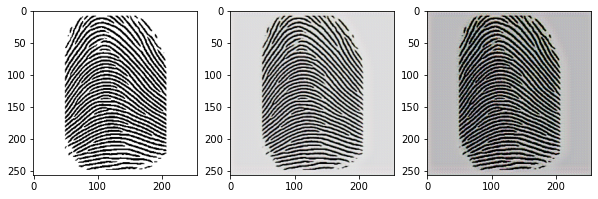

In [ ]:
PredTransformedImageKey = GenModelKey.predict(OriginalImageKey)
PredTransformedImageKey = (PredTransformedImageKey + 1) / 2.0

OutputImageKey = PredTransformedImageKey[0]
OutputImageKeyG = cv2.cvtColor(np.array(OutputImageKey), cv2.COLOR_BGR2GRAY)
dst2 = cv2.cornerHarris(OutputImageKeyG, 2, 3, 0.05)
dst2 = cv2.dilate(dst2,None)
ret1, dst2 = cv2.threshold(dst2,0.05*dst2.max(),255,0)
HCImageK = np.uint8(dst2)

f,plot = plt.subplots(1,3,figsize=(10,10))
plot[0].imshow(OriginalImageKey[0])
plot[1].imshow(PredTransformedImageKey[0])
plot[2].imshow(ManTransformedImageKey[0])

In [ ]:
#saveimage = torchvision.transforms.ToPILImage()(np.uint8(PredTransformedImageKey[0]*255))
#saveimage.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/FINAL RESULTS/Left Loop to Arch/Target Image RL1_1.jpg", dpi=(500,500))

saveimage = torchvision.transforms.ToPILImage()(np.uint8(OriginalImageKey[0]*255))
saveimage.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/FINAL RESULTS/Left Loop to Arch/Key Image RL1_1.jpg", dpi=(500,500))

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}

GenModelAct = load_model('/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/Gmodel2_LL-A(AtoB).h5', cust,compile=True)
#GenModelAct = load_model("/content/drive/MyDrive/Fingerprint GANs/C-GANs_Final/TrainedModels_Final/GModel_RL-LL(A-B).h5", cust)

OriginalImageSource = cv2.imread('/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop/1.jpg',0)
#img_array = cv2.imread('/content/drive/My Drive/Fingerprint GANs/real dataset/contact-based_fingerprints/second_session/234_1.jpg',0)

last_conv_layer_name ='conv2d_3'
#last_conv_layer_name ='conv2d_46'
#last_conv_layer_name ='conv2d_20'

#INTRODUCING KEY IMAGE INTO SOURCE IMAGE

In [ ]:
X_test=[]
Y_test=[]

ClassifierModel = tf.keras.models.load_model('/content/drive/My Drive/Fingerprint GANs/Classification_model/Resnet_Final.h5')
# increase alpha value(500) for better results (atleast upto 5k) 
for ii in range(0,500):
  alpha=[]
  last_conv_layer_output, OriginalSourceImage = GetLastConvLayerOutput(GenModelAct, OriginalImageSource, last_conv_layer_name)
  last_conv_layer_output_source = last_conv_layer_output.numpy()
  PredTransformedSourceImage = GenModelAct.predict(OriginalSourceImage)
  PredTransformedSourceImage = (PredTransformedSourceImage + 1) / 2.0
  OutputImage = PredTransformedSourceImage[0]

  ## Getting harris corner detected features
  OutputImageG = cv2.cvtColor(np.array(OutputImage), cv2.COLOR_BGR2GRAY)
  dst2 = cv2.cornerHarris(OutputImageG, 2, 3, 0.05)
  dst2 = cv2.dilate(dst2,None)
  ret1, dst2 = cv2.threshold(dst2,0.05*dst2.max(),255,0)
  HCImageS = np.uint8(dst2)
  last_conv_layer_output_final = last_conv_layer_output_source
  for ii in range(0,256):
    x = random.randint(0,10)
    alpha.append(x)
    last_conv_layer_output_final[0,:,:,ii] = x*last_conv_layer_output_source[0,:,:,ii] + (10- x)*last_conv_layer_output_key[0,:,:,ii]
  ManTransformedSourceImage = Upsampled_AtoBmodel(GenModelAct, last_conv_layer_output_final)
  X_test.append(alpha)

  ManTransformedSourceImageG = cv2.cvtColor(np.array(ManTransformedSourceImage[0]), cv2.COLOR_BGR2GRAY)
  dst = cv2.cornerHarris(ManTransformedSourceImageG, 2, 3, 0.05)
  dst = cv2.dilate(dst,None)
  ret, dst = cv2.threshold(dst,0.05*dst.max(),255,0)
  HCImageT = np.uint8(dst)

  ## Taking classification probability of Arch Class of the generated image
  MTSI= np.resize(np.array(ManTransformedSourceImage[0]),(1,224,224,3))
  ClassificationScore = ClassifierModel.predict(MTSI)[0][4]

  (SourceGenImDiffScore, diff) = compare_ssim(HCImageT, HCImageS, full=True)
  (KeyGenImDiffScore, diff) = compare_ssim(HCImageT, HCImageK, full=True)
  Y_test.append(SourceGenImDiffScore*3 + KeyGenImDiffScore*3 + ClassificationScore*4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

In [ ]:
# Using regression to get best fit of alpha for best generated image possible

reg = LinearRegression().fit(X_test, Y_test)

AlphaBestFit=[]
for ii in range(0,256):
  if reg.coef_[ii] >0:
    AlphaBestFit.append(10)
  else:
    AlphaBestFit.append(0)

In [ ]:
## USE IF ALPHA NEEDS TO BE CONSTANT ##

last_conv_layer_output, OriginalSourceImage = GetLastConvLayerOutput(GenModelAct, OriginalImageSource, last_conv_layer_name)
last_conv_layer_output_source = last_conv_layer_output.numpy()

PredTransformedSourceImage = GenModelAct.predict(OriginalSourceImage)
PredTransformedSourceImage = (PredTransformedSourceImage + 1) / 2.0
OutputImage = PredTransformedSourceImage[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


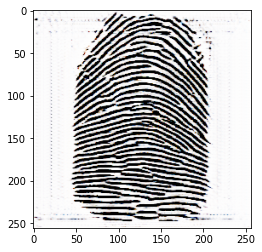

In [ ]:
lclayer = last_conv_layer_output_source
for ii in range(0,256):
  x = AlphaBestFit[ii]
  lclayer[0,:,:,ii] = x*last_conv_layer_output_source[0,:,:,ii] + (10- x)*last_conv_layer_output_key[0,:,:,ii]
FinalImage = Upsampled2_AtoBmodel(GenModelAct, lclayer)

GenImageTweaked = np.array(255*FinalImage[0], np.uint8)
GenImage = np.array(255*OutputImage, np.uint8)

plt.imshow(FinalImage[0], cmap='gray')

In [ ]:
saveimage = torchvision.transforms.ToPILImage()(np.uint8(FinalImage[0]*255))
saveimage.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/FINAL RESULTS/Left Loop to Arch/Stolen_Token-Target Image LL2_3(RL1_1).jpg", dpi=(500,500))

#saveimage = torchvision.transforms.ToPILImage()(np.uint8(OutputImage*255))
#saveimage.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/FINAL RESULTS/Left Loop to Arch/Target Image LL3_3.jpg", dpi=(500,500))

#saveimage = torchvision.transforms.ToPILImage()(np.uint8(OriginalSourceImage[0]*255))
#saveimage.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/FINAL RESULTS/Left Loop to Arch/Source Image LL3_3.jpg", dpi=(500,500))

#IMAGE CROPPING WITH CLASSIFICATION HEAT MAP

In [ ]:
ClassifierModel.layers[-1].activation = None
last_conv_layer_name = "conv5_block3_out"
img_size = (256,256)

x_test2 = np.reshape(preprocessing_fun1(GenImageTweaked),(1,224,224,3))
heatmap = make_gradcam_heatmap(x_test2, ClassifierModel, last_conv_layer_name)

In [ ]:
img_with_hm,img = save_and_display_gradcam(GenImageTweaked, heatmap)
box_size=[215,185]
imgfinal = cropped_best_image(img_with_hm,img,box_size)
GenImageTweakedC = image_enhancer.enhance(imgfinal)

In [ ]:
img_with_hm,img = save_and_display_gradcam(GenImage, heatmap)
box_size=[210,175]
imgfinal = cropped_best_image(img_with_hm,img,box_size)
GenImageC = image_enhancer.enhance(imgfinal)

In [ ]:
im2123 = torchvision.transforms.ToPILImage()(np.uint8(GenImageTweakedC*255))
im2133 = torchvision.transforms.ToPILImage()(np.uint8(GenImageC*255))

im2123.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/Results/Final results_ASI/01.jpg", dpi=(500,500))
im2133.save("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/Results/Final results_ASI/02.jpg", dpi=(500,500))

#Taking scores

In [ ]:
import os
cust = {'InstanceNormalization': InstanceNormalization}

GenModelAct = load_model('/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/Gmodel2_LL-A(AtoB).h5', cust,compile=True)
#GenModelAct = load_model("/content/drive/MyDrive/Fingerprint GANs/C-GANs_Final/TrainedModels_Final/GModel_RL-LL(A-B).h5", cust)

OriginalImageSource = cv2.imread('/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop/1.jpg',0)
#img_array = cv2.imread('/content/drive/My Drive/Fingerprint GANs/real dataset/contact-based_fingerprints/second_session/234_1.jpg',0)

#last_conv_layer_name ='conv2d_3'
last_conv_layer_name ='conv2d_46'
folder = '/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop'
ClassifierModel.layers[-1].activation = None
for filename in os.listdir(folder):
  OriginalImageSource = cv2.imread(os.path.join(folder,filename),0)
  last_conv_layer_output, OriginalSourceImage = GetLastConvLayerOutput(GenModelAct, OriginalImageSource, last_conv_layer_name)
  last_conv_layer_output_source = last_conv_layer_output.numpy()

  PredTransformedSourceImage = GenModelAct.predict(OriginalSourceImage)
  PredTransformedSourceImage = (PredTransformedSourceImage + 1) / 2.0
  OutputImage = PredTransformedSourceImage[0]
  lclayer = last_conv_layer_output_source
  for ii in range(0,256):
    x = AlphaBestFit[ii]
    lclayer[0,:,:,ii] = x*last_conv_layer_output_source[0,:,:,ii] + (10- x)*last_conv_layer_output_key[0,:,:,ii]
  FinalImage = Upsampled2_AtoBmodel(GenModelAct, lclayer)
  saveimage = torchvision.transforms.ToPILImage()(np.uint8(FinalImage[0]*255))
  saveimage.save("/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop/Fake_Arch(Key-LL)/LL-A(LL)_" +str(filename) + ".jpg", dpi=(500,500))

  GenImageTweaked = np.array(255*FinalImage[0], np.uint8)
  last_conv_layer_name1 = "conv5_block3_out"
  img_size = (256,256)

  x_test2 = np.reshape(preprocessing_fun1(GenImageTweaked),(1,224,224,3))
  heatmap = make_gradcam_heatmap(x_test2, ClassifierModel, last_conv_layer_name1)
  img_with_hm,img = save_and_display_gradcam(GenImageTweaked, heatmap)
  box_size=[215,185]
  imgfinal = cropped_best_image(img_with_hm,img,box_size)
  GenImageTweakedC = image_enhancer.enhance(imgfinal)
  im2123 = torchvision.transforms.ToPILImage()(np.uint8(GenImageTweakedC*255))
  im2123.save("/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop/Fake_Arch(Key-LL) Cropped/Cropped-LL-A(LL)_" +str(filename) + ".jpg", dpi=(500,500))

In [ ]:
import os

cust = {'InstanceNormalization': InstanceNormalization}
GenModelKey = load_model("/content/drive/My Drive/Fingerprint GANs/C-GANs_Final/TrainedModels_upd/Gmodel2_LL-A(AtoB).h5", cust)

folder = '/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop/Original'

ClassifierModel = tf.keras.models.load_model('/content/drive/My Drive/Fingerprint GANs/Classification_model/Resnet_Final.h5')
ClassifierModel.layers[-1].activation = None

for filename in os.listdir(folder):
  OriginalImage = cv2.imread(os.path.join(folder,filename),0)
  last_conv_layer_name = 'conv2d_3'
  last_conv_layer_output, OriginalImage = GetLastConvLayerOutput(GenModelKey, OriginalImage, last_conv_layer_name)
  PredTransformedImageKey = GenModelKey.predict(OriginalImage)
  PredTransformedImageKey = (PredTransformedImageKey + 1) / 2.0
  OutputImageKey = np.array(255*PredTransformedImageKey[0], np.uint8)

  last_conv_layer_name1 = "conv5_block3_out"
  img_size = (256,256)

  x_test2 = np.reshape(preprocessing_fun1(OutputImageKey),(1,224,224,3))
  heatmap = make_gradcam_heatmap(x_test2, ClassifierModel, last_conv_layer_name1)
  img_with_hm,img = save_and_display_gradcam(OutputImageKey, heatmap)
  box_size=[215,185]
  imgfinal = cropped_best_image(img_with_hm,img,box_size)
  GenImageTweakedC = image_enhancer.enhance(imgfinal)
  im2123 = torchvision.transforms.ToPILImage()(np.uint8(GenImageTweakedC*255))
  im2123.save("/content/drive/My Drive/Fingerprint GANs/FINAL_DATA/Left_Loop/Fake_Arch(without key) Cropped/Cropped-LL-A(WK)_" +str(filename) + ".jpg", dpi=(500,500))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)
 (256, 256, 3)


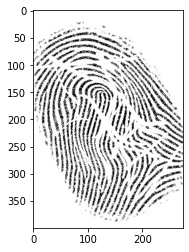

In [ ]:
plt.imshow(OriginalImageSource)

#writing to 

In [ ]:
pip install pandas
pip install xlsxwriter
pip install xlrd
pip install openpyxl